# 04 - Model Evaluation and Kaggle Submission

**Purpose**: Evaluate best model and generate predictions for Kaggle competition.

**Outputs**: Prediction analysis, Kaggle submission file

## 1. Import Libraries and Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [ ]:
# Load validation data for evaluation
X_val = np.load('../data/processed/X_val.npy')
y_val = np.load('../data/processed/y_val.npy')

# Load test data for Kaggle submission
X_test = np.load('../data/processed/X_test.npy')
test_indices = np.load('../data/processed/test_indices.npy')

print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Validation set: (20000, 20)
Test set: (100000, 20)


## 2. Load Best Model

In [ ]:
# Identify which model performed best in previous notebook
with open('../models/best_model.txt', 'r') as f:
    best_model_name = f.read().strip()

print(f"Best model: {best_model_name}")

# Load the corresponding model
# Map model names to file paths
model_paths = {
    'Random Forest': '../models/random_forest.pkl',
    'XGBoost': '../models/xgboost.pkl',
    'Neural Network': '../models/neural_network.keras'
}

model_path = model_paths[best_model_name]

# Load model (different loading method for Neural Network)
if best_model_name == 'Neural Network':
    from tensorflow import keras
    model = keras.models.load_model(model_path)
else:
    model = joblib.load(model_path)

print(f"Model loaded from: {model_path}")

Best model: XGBoost
Model loaded from: ../models/xgboost.pkl


## 3. Validation Set Evaluation

In [4]:
# Generate predictions on validation set
# Validation set was not used during training (unseen data)
if best_model_name == 'Neural Network':
    y_pred = model.predict(X_val, verbose=0).flatten()
else:
    y_pred = model.predict(X_val)

print(f"Predictions generated for {len(y_pred)} samples")

Predictions generated for 20000 samples


In [5]:
# Calculate evaluation metrics
# RMSE: penalizes large errors more than MAE
# MAE: average absolute prediction error
# R²: percentage of variance explained (1.0 = perfect)
# MAPE: percentage error (interpretable)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100

print("\n" + "="*50)
print(f"FINAL MODEL EVALUATION: {best_model_name}")
print("="*50)
print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print("="*50)


FINAL MODEL EVALUATION: XGBoost
RMSE: 179,695.82
MAE: 145,000.47
R²: 0.9990
MAPE: 0.99%


## 4. Prediction Analysis

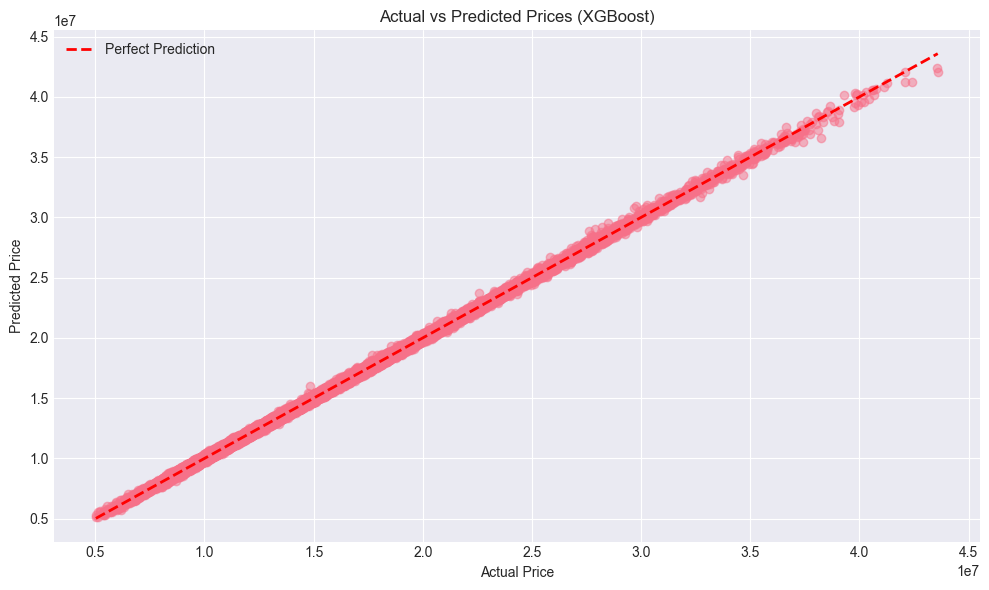

In [6]:
# Actual vs Predicted scatter plot
# Perfect predictions would lie on diagonal line (y=x)
# Scatter indicates prediction uncertainty

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Actual vs Predicted Prices ({best_model_name})')
plt.legend()
plt.tight_layout()
plt.show()

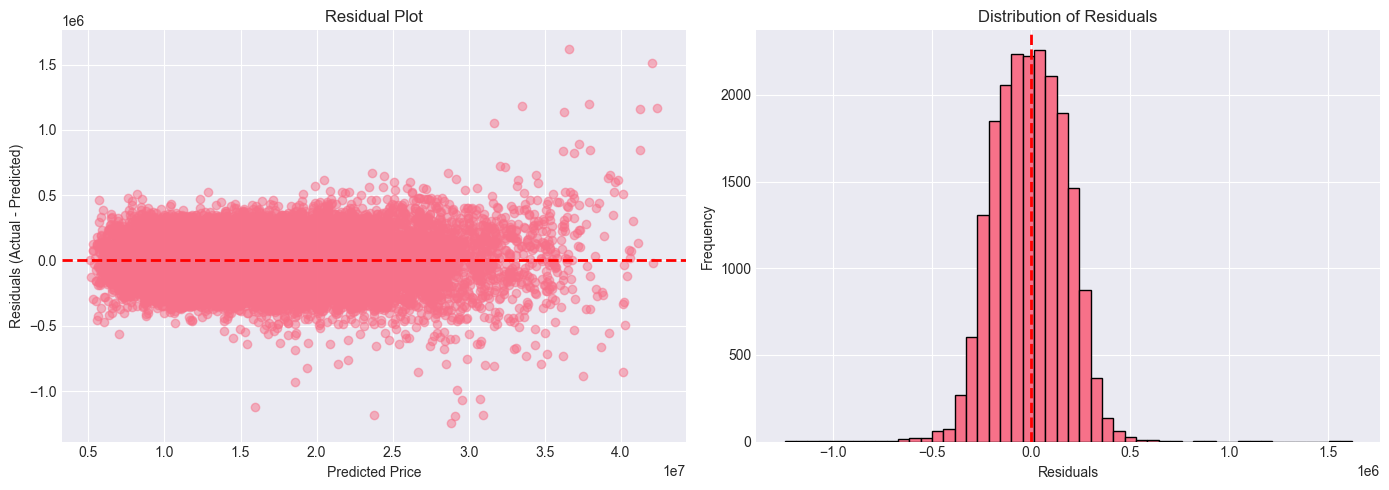

In [7]:
# Residual analysis
# Residuals = Actual - Predicted
# Random scatter around zero indicates good model fit
# Patterns suggest model bias or missing features

residuals = y_val - y_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual plot
axes[0].scatter(y_pred, residuals, alpha=0.5)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Price')
axes[0].set_ylabel('Residuals (Actual - Predicted)')
axes[0].set_title('Residual Plot')

# Residual distribution
axes[1].hist(residuals, bins=50, edgecolor='black')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Residuals')
axes[1].axvline(x=0, color='r', linestyle='--', lw=2)

plt.tight_layout()
plt.show()

In [8]:
# Residual statistics
# Mean should be close to zero (unbiased predictions)
# Normal distribution indicates good model assumptions

print("Residual Statistics:")
print(f"Mean: {residuals.mean():,.2f}")
print(f"Std: {residuals.std():,.2f}")
print(f"Min: {residuals.min():,.2f}")
print(f"Max: {residuals.max():,.2f}")

Residual Statistics:
Mean: -3,852.77
Std: 179,654.51
Min: -1,243,616.00
Max: 1,618,702.00


## 5. Feature Importance (If Applicable)

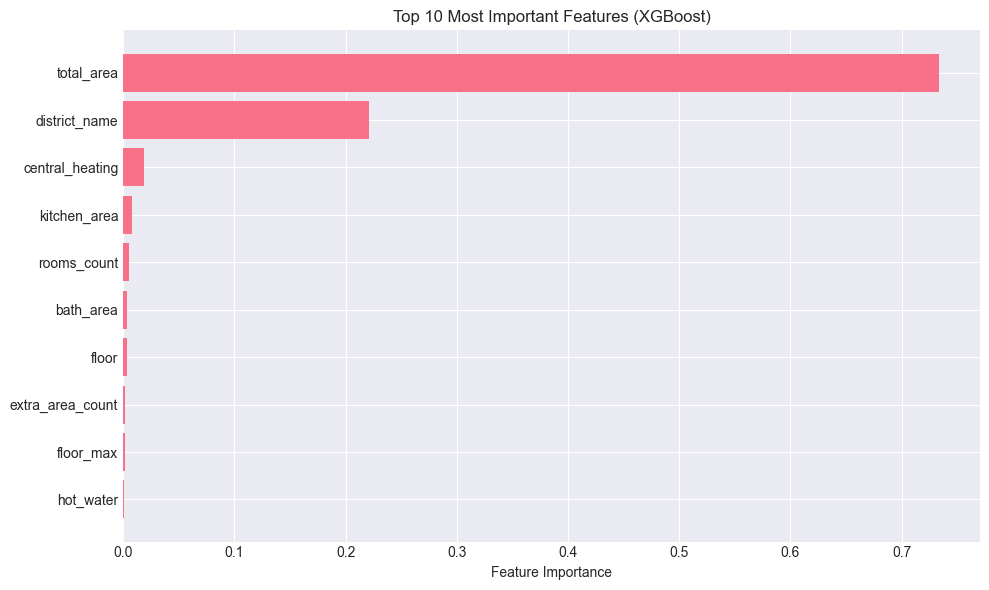


Top 5 Features:
1. total_area: 0.7337
2. district_name: 0.2208
3. central_heating: 0.0186
4. kitchen_area: 0.0077
5. rooms_count: 0.0052


In [9]:
# Feature importance available for tree-based models
# Shows which features contribute most to predictions

if best_model_name in ['Random Forest', 'XGBoost']:
    feature_names = open('../data/processed/feature_names.txt').read().split('\n')
    
    if best_model_name == 'XGBoost':
        importances = model.feature_importances_
    else:
        importances = model.feature_importances_
    
    # Sort and plot top 10 features
    indices = np.argsort(importances)[::-1][:10]
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(10), importances[indices])
    plt.yticks(range(10), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 10 Most Important Features ({best_model_name})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 5 Features:")
    for i in range(5):
        print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
else:
    print(f"Feature importance not available for {best_model_name}")

## 6. Generate Test Set Predictions

In [10]:
# Generate predictions on test set for Kaggle submission
# Test set has no price labels (competition evaluation)

if best_model_name == 'Neural Network':
    test_predictions = model.predict(X_test, verbose=0).flatten()
else:
    test_predictions = model.predict(X_test)

# Ensure all predictions are positive (prices cannot be negative)
test_predictions = np.maximum(test_predictions, 0)

print(f"Generated {len(test_predictions)} predictions for test set")
print(f"\nPrediction statistics:")
print(f"Min: {test_predictions.min():,.2f}")
print(f"Max: {test_predictions.max():,.2f}")
print(f"Mean: {test_predictions.mean():,.2f}")
print(f"Median: {np.median(test_predictions):,.2f}")

Generated 100000 predictions for test set

Prediction statistics:
Min: 5,047,848.00
Max: 42,727,764.00
Mean: 15,991,698.00
Median: 14,868,515.00


## 7. Create Kaggle Submission File

In [11]:
# Create submission DataFrame in required format
# Kaggle expects: index (from test data), price (predictions)

submission = pd.DataFrame({
    'index': test_indices,
    'price': test_predictions
})

# Verify submission format
print("Submission DataFrame:")
print(submission.head(10))
print(f"\nShape: {submission.shape}")
print(f"Columns: {list(submission.columns)}")

Submission DataFrame:
   index       price
0      0  18089692.0
1      1  15741815.0
2      2  12253533.0
3      3   9952354.0
4      4   9740641.0
5      5  38417244.0
6      6  18601314.0
7      7  19918658.0
8      8  22606256.0
9      9  16934642.0

Shape: (100000, 2)
Columns: ['index', 'price']


In [12]:
# Save submission file
# CSV format required by Kaggle
submission_path = '../submissions/final_submission.csv'
submission.to_csv(submission_path, index=False)

print(f"\nSubmission file saved to: {submission_path}")
print(f"Ready for upload to Kaggle competition!")
print(f"\nUpload at: https://www.kaggle.com/competitions/itmo-flat-price-prediction-2025-2026/submit")


Submission file saved to: ../submissions/final_submission.csv
Ready for upload to Kaggle competition!

Upload at: https://www.kaggle.com/competitions/itmo-flat-price-prediction-2025-2026/submit
